# 1. import

In [4]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# 커스텀 파이토치 데이터셋 / 모델 + 유틸 함수 import
from data_utils import *
from feature_eng import *

torch.manual_seed(12345)
random.seed(12345)
np.random.seed(12345)

# 2. 데이터 정보 + 상수 선언

In [ ]:
aws_df = combine_df('./TRAIN_AWS/', './META/awsmap.csv')
pm_df = combine_df('./TRAIN/', './META/pmmap.csv')

## 2.1 기상 관측소 (AWS) 데이터

In [2]:
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051920 entries, 0 to 35063
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   연도         1051920 non-null  int64  
 1   일시         1051920 non-null  object 
 2   지점         1051920 non-null  object 
 3   기온(°C)     1032972 non-null  float64
 4   풍향(deg)    1032972 non-null  float64
 5   풍속(m/s)    1032972 non-null  float64
 6   강수량(mm)    1032972 non-null  float64
 7   습도(%)      1032972 non-null  float64
 8   Latitude   1051920 non-null  float64
 9   Longitude  1051920 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 88.3+ MB


## 2.2 미세먼지 관측소 (PM) 데이터

In [3]:
pm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596088 entries, 0 to 35063
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   연도         596088 non-null  int64  
 1   일시         596088 non-null  object 
 2   측정소        596088 non-null  object 
 3   PM2.5      580546 non-null  float64
 4   Latitude   596088 non-null  float64
 5   Longitude  596088 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 31.8+ MB


## 2. 3 상수 선언

In [14]:
num_aws = 30           # 총 기상 관측소 개수
num_pm = 17            # 총 미세먼지 관측소 개수
num_neighbors = 5      # 예측시 고려할 근처 관측소 개수
num_aws_features = 7   # 기상 특성 개수
num_pm_features = 8    # 기상 특성 + 미세먼지 특성 개수
num_timestamps = len(aws_df.groupby(['연도', '일시']).groups)

aws_dir = './TRAIN_AWS/'

# 3. AWS 예측 모델

## 3.1 전처리

In [7]:
# 위도 경도 정보 불러오기 + 위치 명 정수화 하기
region_encoder = OrdinalEncoder()
meta_df = pd.read_csv('./META/awsmap.csv')
meta_df['지점'] = meta_df['Location'].copy()
meta_df['Location'] = region_encoder.fit_transform(meta_df['지점'].to_frame())
meta_df = meta_df.iloc[:, :-2].sort_values(by='Location')
meta_df = pd.DataFrame(meta_df, index=meta_df['Location'], columns=['Latitude', 'Longitude'])

In [37]:
# 정수화된 지점 아이디와 지점 이름 매핑
regions = list(region_encoder.inverse_transform(np.array(range(30)).reshape(-1, 1)).flatten())
id_to_region = dict(zip(range(30), regions))
regions_to_id = dict(zip(regions, range(30)))

# 각 관측소 별 근처 5개의 관측소 구하기
neighbors = {}
for i in range(30):
    point = meta_df.iloc[i]
    temp = meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_neighbors + 1]]

## 3.2 데이터 numpy array로 적제 후 PyTorch 데이터셋 생성하기

In [15]:
data = np.zeros((num_timestamps, num_aws, num_aws_features), float)
data[:, :, :] = np.nan

for i in range(30):
    aws_df = pd.read_csv(aws_dir + id_to_region[i] + '.csv')
    features = aws_df.values[:,3:]
    lat = meta_df.iloc[i, 0]
    long = meta_df.iloc[i, 1]
    data[:, i, :-2] = features
    data[:, i, -2:] = np.array([lat, long])

In [20]:
# 훈련셋 검증셋 나누기
dataset = AWSTrainDataset(data, num_aws=num_neighbors, time_size=10, neighbors=neighbors)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=12345)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)

## 3.3 AWS 모델 훈련

In [28]:
# 하이퍼 파라미터
num_lstm_out = 5
hidden_size = 20
time_size = 10
batch_size = 12
lr = 0.05
patience = 2
epochs = 30
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 데이터로더
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))
train_iter = iter(trainloader)
valid_iter = iter(validloader)

# 모델 생성 
model = FeatureSeqNet(num_aws=num_neighbors, num_features=num_aws_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 객체 생성
optimizer = optim.Adagrad(lr=lr, params=model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, mode='min', verbose=True)
loss_fn = nn.MSELoss()

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[]}

In [29]:
# 훈련 루프
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    model.eval()
    val_loss = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()

    val_loss /= valid_steps
    metrics['valid'].append(val_loss)
    scheduler.step(val_loss)
    
    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}')

Validation epoch 1 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 203.91it/s]


Metrics: Train Loss: 0.015961606820759144, Valid Loss: 0.014971890439711893


Validation epoch 2 : 100%|█████████████████████████████████████| 1752/1752 [00:07<00:00, 223.03it/s]


Metrics: Train Loss: 0.014873180931725072, Valid Loss: 0.014691683980925341


Validation epoch 3 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 215.25it/s]


Metrics: Train Loss: 0.01460316225454933, Valid Loss: 0.014698503582416778


Validation epoch 4 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 216.51it/s]


Metrics: Train Loss: 0.014516754220439314, Valid Loss: 0.01457145885853718


Validation epoch 5 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 218.33it/s]


Metrics: Train Loss: 0.014371240385302993, Valid Loss: 0.014278767244235652


Validation epoch 6 : 100%|█████████████████████████████████████| 1752/1752 [00:07<00:00, 219.87it/s]


Metrics: Train Loss: 0.014313364039971256, Valid Loss: 0.014246761686797815


Validation epoch 7 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 213.89it/s]


Metrics: Train Loss: 0.014218630095169086, Valid Loss: 0.014258865844194222


Validation epoch 8 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 212.79it/s]


Metrics: Train Loss: 0.014248640702763873, Valid Loss: 0.014351534024668329


Validation epoch 9 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 213.02it/s]


Epoch 00009: reducing learning rate of group 0 to 5.0000e-03.
Metrics: Train Loss: 0.014183063611101466, Valid Loss: 0.014248033123664081


Validation epoch 10 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 210.74it/s]


Metrics: Train Loss: 0.01401440972033273, Valid Loss: 0.014131299129888763


Validation epoch 11 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 211.16it/s]


Metrics: Train Loss: 0.014064373440971584, Valid Loss: 0.014187867152699747


Validation epoch 12 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 219.02it/s]


Metrics: Train Loss: 0.014014139215213772, Valid Loss: 0.014056824612280066


Validation epoch 13 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 216.18it/s]


Metrics: Train Loss: 0.014061252132919958, Valid Loss: 0.01407927913630693


Validation epoch 14 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 213.18it/s]


Metrics: Train Loss: 0.014047964668612672, Valid Loss: 0.014059758057880466


Validation epoch 15 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 217.61it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Metrics: Train Loss: 0.014050762454343318, Valid Loss: 0.014060517453646218


Validation epoch 16 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 215.84it/s]


Metrics: Train Loss: 0.014128827489903352, Valid Loss: 0.013983727284602995


Validation epoch 17 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 221.11it/s]


Metrics: Train Loss: 0.013985671387562888, Valid Loss: 0.014021089328411037


Validation epoch 18 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 215.39it/s]


Metrics: Train Loss: 0.014025243645369988, Valid Loss: 0.014059478764931067


Validation epoch 19 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 215.50it/s]


Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Metrics: Train Loss: 0.013946504179122231, Valid Loss: 0.014067230003429198


Validation epoch 20 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 216.71it/s]


Metrics: Train Loss: 0.014105275374072334, Valid Loss: 0.014156505031997538


Validation epoch 21 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 199.50it/s]


Metrics: Train Loss: 0.014097616116150452, Valid Loss: 0.014061461233549405


Validation epoch 22 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 200.64it/s]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-06.
Metrics: Train Loss: 0.013976587108765212, Valid Loss: 0.014011941207235902


Validation epoch 23 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 208.97it/s]


Metrics: Train Loss: 0.013973254670774383, Valid Loss: 0.014045468060823425


Validation epoch 24 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 211.41it/s]


Metrics: Train Loss: 0.014015126812126258, Valid Loss: 0.014052620032459558


Validation epoch 25 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 214.45it/s]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-07.
Metrics: Train Loss: 0.014034641289633842, Valid Loss: 0.014232606237545348


Validation epoch 26 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 214.47it/s]


Metrics: Train Loss: 0.014009349801098813, Valid Loss: 0.013966349943302083


Validation epoch 27 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 220.76it/s]


Metrics: Train Loss: 0.013967645620019039, Valid Loss: 0.0138529176858361


Validation epoch 28 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 221.49it/s]


Metrics: Train Loss: 0.014001294823678586, Valid Loss: 0.01405839579112619


Validation epoch 29 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 221.59it/s]


Metrics: Train Loss: 0.014168396102740925, Valid Loss: 0.014081529446522101


Validation epoch 30 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 180.33it/s]

Epoch 00030: reducing learning rate of group 0 to 5.0000e-08.
Metrics: Train Loss: 0.014006538051382056, Valid Loss: 0.014042156401889265


## 3.4 AWS 모델 훈련 시각화

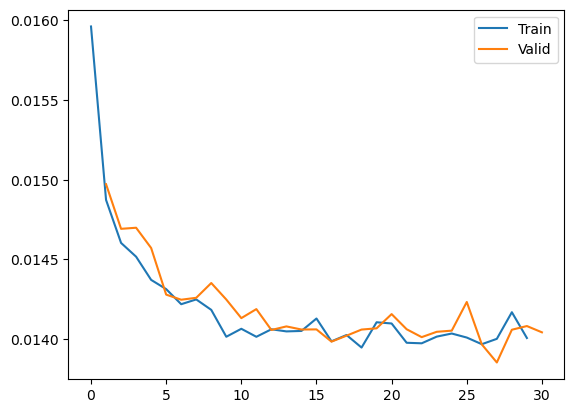

In [32]:
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()

## 3.5 AWS 결측치 예측

In [40]:
# 시간 (index)과 관측소 (column)별로 측정값이 있는지 없는지 계산하여 DataFrame 형식으로 리턴
def null_time_intervals(root_dir, metadata_path, regions_to_id):
    dfs = []
    meta_df = pd.read_csv(metadata_path)
    for i in range(meta_df.shape[0]):
        csv_path = meta_df.iloc[i]['Location'] + '.csv'
        measure_df = pd.read_csv(root_dir + csv_path)
        null_datapoints = measure_df.isnull().sum(axis=1) > 0
        dfs.append(null_datapoints)
    result = pd.DataFrame()
    for i in range(meta_df.shape[0]):
        result[regions_to_id[meta_df.iloc[i]['Location']]] = dfs[i]
    return pd.DataFrame(result, columns=list(range(num_aws)))

# 결측값들의 (time_idx, aws_idx)의 리스트 만들기
null_times = null_time_intervals('./TRAIN_AWS/', './META/awsmap.csv', regions_to_id)
null_list = []
for time_idx in range(num_timestamps):
    for aws_idx in range(num_aws):
        if null_times.iloc[time_idx, aws_idx]:
            null_list.append((time_idx, aws_idx))

In [47]:
# 결측치 채우기
model.eval()
spatial_enc = model.spatial_encoder
seq_enc = model.sequential_encoder
decoder = model.decoder


data = dataset.data
for time_idx, aws_idx in null_list:
    inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
    spatial_x = spatial_enc(inputs.unsqueeze(0).double())
    cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
    output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
    output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
    if np.isnan(output.detach().numpy()).sum() > 0:
        raise Exception()
    data[time_idx, aws_idx, :-2] = output.detach().numpy()

## 3.6 AWS 모델 이용하여 PM 관측소의 기상정보 예측

In [61]:
# pm
pm_encoder = OrdinalEncoder()
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.fit_transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

neighbors = {}
num_aws = 5
for i in range(17):
    point = pm_meta_df.iloc[i]
    temp = meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_aws + 1]]

    ids = np.arange(17).reshape(-1, 1)
pms = pm_encoder.inverse_transform(ids).flatten()
pm_to_id = dict(zip(pms, ids.flatten()))
id_to_pm = dict(zip(ids.flatten(), pms))

In [51]:
pm_data = np.zeros((num_timestamps, 17, 7))
for time_idx in tqdm(range(10, num_timestamps), ncols=100):
    for pm_idx in range(17):
        pm_pos = list(pm_meta_df.iloc[pm_idx])
        inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
        spatial_x = spatial_enc(inputs.unsqueeze(0).double())
        cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
        output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
        output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
        if np.isnan(output.detach().numpy()).sum() > 0:
            raise Exception()
        pm_data[time_idx, pm_idx, :-2] = output.detach().numpy()
        pm_data[time_idx, pm_idx, -2:] = pm_pos

100%|█████████████████████████████████████████████████████████| 35054/35054 [12:03<00:00, 48.47it/s]


# 4. PM 예측 모델

## 4.1 PM 데이터 전처리

In [52]:
# 0번째 특성 PM2.5 추가
data = np.zeros((pm_data.shape[0], pm_data.shape[1], pm_data.shape[2] + 1))
data[:, :, 1:] = pm_data[:, :, :]
data[:10, :, 3] = np.nan
data[:, :, 0] = np.nan

for i in range(num_pm):
    df = pd.read_csv(f'./TRAIN/{id_to_pm[i]}.csv')
    for time_idx in range(data.shape[0]):
        data[time_idx, i, 0] = df.iloc[time_idx]['PM2.5']

In [66]:
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

neighbors = {}
num_aws = 5
for i in range(17):
    point = pm_meta_df.iloc[i]
    temp = pm_meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_aws + 1]]

## 4.2 PyTorch 데이터셋 생성하기

In [67]:
dataset = PMTrainDataset(data, num_aws=num_neighbors, time_size=time_size, neighbors=neighbors)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=12345)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))

## 4.3 PM 모델 훈련

In [70]:
# 하이퍼파라미터
num_lstm_out = 6
lr = 0.05
patience = 2
epochs = 30
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 모델 생성
model = FeatureSeqNet(num_aws=num_neighbors, num_features=num_pm_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 생성
optimizer = optim.Adagrad(lr=lr, params=model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, mode='min', verbose=True)
loss_fn = nn.MSELoss()
train_iter = iter(trainloader)
valid_iter = iter(validloader)
mae = nn.L1Loss() # 대회 평가기준. 검증셋 평가용

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[], 'mae':[]}

In [71]:
# 훈련 루프
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    model.eval()
    val_loss = 0
    val_mae = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = model(inputs, targets)
        pm_out = output[:, :, 0].view(-1)
        pm_target = targets[:, :, 0].view(-1)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()
        val_mae += mae(pm_out, pm_target).item()

    val_loss /= valid_steps
    val_mae /= valid_steps
    metrics['valid'].append(val_loss)
    metrics['mae'].append(val_mae)
    scheduler.step(val_mae)
    
    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}, Valid MAE: {val_mae}')

Validation epoch 1 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 194.98it/s]


Metrics: Train Loss: 0.004460872218620901, Valid Loss: 0.0032536521516516744, Valid MAE: 0.02007098775889642


Validation epoch 2 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 187.36it/s]


Metrics: Train Loss: 0.0031430708240233725, Valid Loss: 0.0028451092587971592, Valid MAE: 0.01993282705215449


Validation epoch 3 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 217.82it/s]


Metrics: Train Loss: 0.002185922018300023, Valid Loss: 0.0017760503344993578, Valid MAE: 0.018756018001576346


Validation epoch 4 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 228.86it/s]


Metrics: Train Loss: 0.0018200714913502746, Valid Loss: 0.0017078243386832554, Valid MAE: 0.01835939975248294


Validation epoch 5 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 214.42it/s]


Metrics: Train Loss: 0.0017107340521885068, Valid Loss: 0.0016180701796495072, Valid MAE: 0.019129661612978542


Validation epoch 6 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 221.32it/s]


Metrics: Train Loss: 0.0015495638245062848, Valid Loss: 0.001441635843467828, Valid MAE: 0.01832680896331954


Validation epoch 7 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 215.70it/s]


Metrics: Train Loss: 0.00143687171638898, Valid Loss: 0.0012442899155951101, Valid MAE: 0.01881456663535396


Validation epoch 8 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 211.39it/s]


Metrics: Train Loss: 0.0013331474843285265, Valid Loss: 0.001144061976229198, Valid MAE: 0.019346818703326735


Validation epoch 9 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 219.03it/s]


Epoch 00009: reducing learning rate of group 0 to 5.0000e-03.
Metrics: Train Loss: 0.0012895669924970685, Valid Loss: 0.0011221850762178915, Valid MAE: 0.019562080747908862


Validation epoch 10 : 100%|██████████████████████████████████████| 992/992 [00:05<00:00, 167.35it/s]


Metrics: Train Loss: 0.0012278483298587411, Valid Loss: 0.0010864512285005494, Valid MAE: 0.018523628265119035


Validation epoch 11 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 209.74it/s]


Metrics: Train Loss: 0.0012148831263317247, Valid Loss: 0.001095851678444042, Valid MAE: 0.01855000567277546


Validation epoch 12 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 202.12it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Metrics: Train Loss: 0.001219832664918537, Valid Loss: 0.0010798399541358213, Valid MAE: 0.01883750690256855


Validation epoch 13 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 209.75it/s]


Metrics: Train Loss: 0.001217236808862871, Valid Loss: 0.0010773060914858737, Valid MAE: 0.018584132724151648


Validation epoch 14 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 215.73it/s]


Metrics: Train Loss: 0.0012155173420120532, Valid Loss: 0.001073655881413186, Valid MAE: 0.018610190088747817


Validation epoch 15 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 205.08it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-05.
Metrics: Train Loss: 0.0012125783117438484, Valid Loss: 0.0010785080102762282, Valid MAE: 0.01849867997432894


Validation epoch 16 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 224.83it/s]


Metrics: Train Loss: 0.0012169084812498861, Valid Loss: 0.00110016960719981, Valid MAE: 0.018729322334667432


Validation epoch 17 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 206.24it/s]


Metrics: Train Loss: 0.0012119844461018704, Valid Loss: 0.0010731351713764296, Valid MAE: 0.018657325651609203


Validation epoch 18 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 218.46it/s]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-06.
Metrics: Train Loss: 0.0012087792544215354, Valid Loss: 0.0010731092720808674, Valid MAE: 0.01853304681595556


Validation epoch 19 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 211.63it/s]


Metrics: Train Loss: 0.0012113403517822394, Valid Loss: 0.0010758381530303006, Valid MAE: 0.018474458300765408


Validation epoch 20 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 222.73it/s]


Metrics: Train Loss: 0.001212953642181255, Valid Loss: 0.0010849232278048767, Valid MAE: 0.01855583363780151


Validation epoch 21 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 221.58it/s]


Metrics: Train Loss: 0.0012050911458672425, Valid Loss: 0.0010725127840034683, Valid MAE: 0.018319140177680326


Validation epoch 22 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 227.72it/s]


Metrics: Train Loss: 0.0012130101051742214, Valid Loss: 0.0010715097683346739, Valid MAE: 0.01847900844718797


Validation epoch 23 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 215.65it/s]


Metrics: Train Loss: 0.001211961929297569, Valid Loss: 0.0010936356608678127, Valid MAE: 0.018780413174733782


Validation epoch 24 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 219.38it/s]


Epoch 00024: reducing learning rate of group 0 to 5.0000e-07.
Metrics: Train Loss: 0.0012079641295701363, Valid Loss: 0.001085348355332057, Valid MAE: 0.01866224609891284


Validation epoch 25 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 220.96it/s]


Metrics: Train Loss: 0.001216921423060859, Valid Loss: 0.0010950567822410292, Valid MAE: 0.018738430400701306


Validation epoch 26 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 213.29it/s]


Metrics: Train Loss: 0.0012123025216944226, Valid Loss: 0.0010884677060327517, Valid MAE: 0.01848724844270692


Validation epoch 27 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 207.29it/s]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-08.
Metrics: Train Loss: 0.0012095998119950385, Valid Loss: 0.0010806948655622298, Valid MAE: 0.018682436125126926


Validation epoch 28 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 211.90it/s]


Metrics: Train Loss: 0.0012148781301157365, Valid Loss: 0.0010749517904233045, Valid MAE: 0.01841986277520345


Validation epoch 29 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 221.91it/s]


Metrics: Train Loss: 0.0012128218639605828, Valid Loss: 0.001087060150029525, Valid MAE: 0.018765259780008266


Validation epoch 30 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 214.51it/s]

Epoch 00030: reducing learning rate of group 0 to 5.0000e-09.
Metrics: Train Loss: 0.0012110458602083846, Valid Loss: 0.0010947828626571674, Valid MAE: 0.01882568439025851


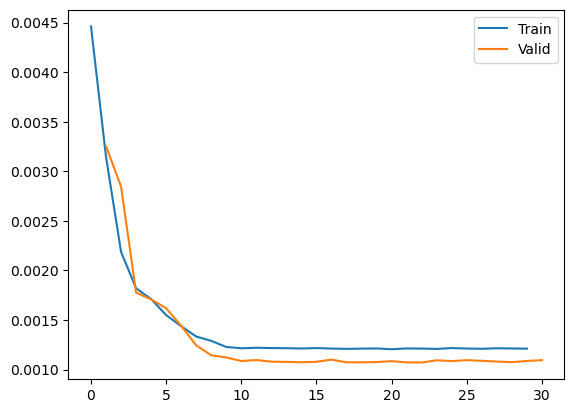

In [72]:
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()